Heatmap Data Processing and Clustering Analysis
Longsheng Xie longsheng.xie41@gmail.com

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import json
from itertools import product, combinations
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

# Function to generate group combinations
def generate_groups(variables):
    values_combinations = list(product(*[var.split('/') for var in variables]))
    return ['_'.join(comb) for comb in values_combinations]

# Function to generate group pairs for comparisons
def generate_group_pairs(groups, variables):
    pairs = []
    num_variables = len(variables)
    if num_variables == 1:
        sorted_groups = sorted(groups, key=lambda x: variables[0].index(x.split('_')[0]))
        return list(combinations(sorted_groups, 2))
    else:
        for var_index in range(num_variables):
            for group1, group2 in combinations(groups, 2):
                parts1, parts2 = group1.split('_'), group2.split('_')
                if len(parts1) < num_variables or len(parts2) < num_variables:
                    continue
                try:
                    if parts1[var_index] != parts2[var_index] and all(
                            parts1[i] == parts2[i] for i in range(num_variables) if i != var_index):
                        if variables[var_index].index(parts1[var_index]) > variables[var_index].index(parts2[var_index]):
                            group1, group2 = group2, group1
                        pairs.append((group1, group2))
                except IndexError:
                    continue
    return pairs


In [ ]:
# Function to preprocess data
def preprocess_data(file_path, config_path):
    # Read configuration file
    with open(config_path, "r") as f:
        config = json.load(f)

    group_variables = config["global"]["group_variables"]
    groups = generate_groups(group_variables)
    comparisons = [f"{a} vs {b}" for a, b in generate_group_pairs(groups, [var.split('/') for var in group_variables])]

    # Read raw data
    raw = pd.read_csv(file_path, na_values=["", "NA", "N/A", "null", "NULL", "Inf", "-Inf"], keep_default_na=True)

    # Prepare column names
    pvalue_cols = [f"Tukey_HSD_P_Value({comp})" for comp in comparisons]
    fold_change_cols = [f"Log2_Fold_Change({comp})" for comp in comparisons]

    # Check if the column exists
    if not all(col in raw.columns for col in pvalue_cols + fold_change_cols):
        raise ValueError("One or more columns are missing in the input file. Check column names.")

    # Data processing
    fold_change_data = raw[fold_change_cols].copy()
    fold_change_data.columns = comparisons
    fold_change_data = fold_change_data.apply(pd.to_numeric, errors='coerce')

    significance_mask = raw[pvalue_cols].apply(pd.to_numeric, errors='coerce') < 0.1
    significance_mask.columns = comparisons

    print("Significant values count per column:")
    print(significance_mask.sum())

    heatmap_data = fold_change_data.where(significance_mask)
    valid_rows, valid_cols = heatmap_data.notna().any(axis=1), heatmap_data.notna().any(axis=0)
    heatmap_data = heatmap_data.loc[valid_rows, valid_cols]
    filtered_raw = raw.loc[valid_rows].copy()

    print(f"\nValid rows: {valid_rows.sum()}, Valid columns: {valid_cols.sum()}")

    if heatmap_data.shape[0] == 0 or heatmap_data.shape[1] == 0:
        raise ValueError("No valid rows or columns available for heatmap.")

    heatmap_data = heatmap_data.fillna(0)

    # Calculate clustering order
    dist_matrix = pdist(heatmap_data.values, metric='euclidean')
    row_linkage = sch.linkage(dist_matrix, method='complete')
    row_order = sch.leaves_list(row_linkage)

    # Rearrange all data according to clustering order
    heatmap_data = heatmap_data.iloc[row_order]
    filtered_raw = filtered_raw.iloc[row_order]

    # Add row numbers and save CSV
    filtered_raw['row_number'] = np.arange(1, len(filtered_raw) + 1)
    all_columns = filtered_raw.columns.tolist()
    selected_columns = ['row_number', 'Name', 'HMDB', 'KEGG'] + [
        col for col in all_columns if col.startswith('Log2_Fold_Change') or col.startswith('Tukey_HSD_P_Value')
    ]
    filtered_raw[selected_columns].to_csv("/clustered_genes_log2fc_significance.csv", index=False)
    print("Clustered gene table saved as 'clustered_genes_log2fc_significance.csv'")

    return heatmap_data

In [ ]:
def find_consecutive_patterns(csv_path, heatmap_columns, threshold=0.1):
    df = pd.read_csv(csv_path)

    col1_prefix = heatmap_columns[0]  # Alb_C vs SPT3hKO_C
    col2_prefix = heatmap_columns[1]  # Alb_E vs SPT3hKO_E
    col3_prefix = heatmap_columns[2]  # Alb_C vs Alb_E
    col4_prefix = heatmap_columns[3]  # SPT3hKO_C vs SPT3hKO_E

    def check_conditions(row, p_cols, fc_cols, fc_positive=True):
        """
        Check if a row meets the p-value and fold change criteria
        fc_positive: True means fold change > 0, False means fold change < 0
        """
        p_values_ok = all(float(row[p_col]) < threshold for p_col in p_cols)
        if fc_positive:
            fc_values_ok = all(float(row[fc_col]) > 0 for fc_col in fc_cols)
        else:
            fc_values_ok = all(float(row[fc_col]) < 0 for fc_col in fc_cols)
        return p_values_ok and fc_values_ok

    def merge_ranges(ranges, max_gap=1):
        """
        Merge ranges that are no farther apart than max_gap
        """
        if not ranges:
            return []

        sorted_ranges = sorted(ranges, key=lambda x: x[0])
        merged = []
        current = sorted_ranges[0]

        for next_range in sorted_ranges[1:]:
            if next_range[0] - current[-1] <= max_gap + 1:
                current = list(range(current[0], next_range[-1] + 1))
            else:
                merged.append(current)
                current = next_range

        merged.append(current)
        return merged

    def get_pattern_ranges(df, conditions_func, label=''):
        pattern = []
        current_streak = []

        for i in range(len(df)):
            row = df.iloc[i]
            meets_criteria = conditions_func(row)

            if meets_criteria:
                if not current_streak:
                    current_streak = [i]
                elif i == current_streak[-1] + 1:
                    current_streak.append(i)
            else:
                if len(current_streak) >= 2:
                    pattern.append(current_streak)
                current_streak = []

        if current_streak and len(current_streak) >= 2:
            pattern.append(current_streak)

        if pattern:
            pattern = merge_ranges(pattern)

        return pattern

    patterns = {}

    def black_conditions_positive(row):
        return check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})", f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})", f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=True
        )

    def orange_conditions_positive(row):
        col1_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})"],
            fc_positive=True
        )
        col2_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=True
        )
        return col1_satisfied and not col2_satisfied

    def green_conditions_positive(row):
        col1_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})"],
            fc_positive=True
        )
        col2_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=True
        )
        return not col1_satisfied and col2_satisfied

    def yellow_conditions_positive(row):
        col3_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col3_prefix})"],
            [f"Log2_Fold_Change({col3_prefix})"],
            fc_positive=True
        )
        col4_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col4_prefix})"],
            [f"Log2_Fold_Change({col4_prefix})"],
            fc_positive=True
        )
        return col3_satisfied and not col4_satisfied

    def cyan_conditions_positive(row):
        col3_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col3_prefix})"],
            [f"Log2_Fold_Change({col3_prefix})"],
            fc_positive=True
        )
        col4_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col4_prefix})"],
            [f"Log2_Fold_Change({col4_prefix})"],
            fc_positive=True
        )
        return not col3_satisfied and col4_satisfied

    # For the pattern where fold change < 0
    def black_conditions_negative(row):
        return check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})", f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})", f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=False
        )

    def orange_conditions_negative(row):
        col1_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})"],
            fc_positive=False
        )
        col2_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=False
        )
        return col1_satisfied and not col2_satisfied

    def green_conditions_negative(row):
        col1_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col1_prefix})"],
            [f"Log2_Fold_Change({col1_prefix})"],
            fc_positive=False
        )
        col2_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col2_prefix})"],
            [f"Log2_Fold_Change({col2_prefix})"],
            fc_positive=False
        )
        return not col1_satisfied and col2_satisfied

    def yellow_conditions_negative(row):
        col3_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col3_prefix})"],
            [f"Log2_Fold_Change({col3_prefix})"],
            fc_positive=False
        )
        col4_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col4_prefix})"],
            [f"Log2_Fold_Change({col4_prefix})"],
            fc_positive=False
        )
        return col3_satisfied and not col4_satisfied

    def purple_conditions_negative(row):
        col3_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col3_prefix})"],
            [f"Log2_Fold_Change({col3_prefix})"],
            fc_positive=False
        )
        col4_satisfied = check_conditions(
            row,
            [f"Tukey_HSD_P_Value({col4_prefix})"],
            [f"Log2_Fold_Change({col4_prefix})"],
            fc_positive=False
        )
        return not col3_satisfied and col4_satisfied

    patterns = {}
    # Fold change > 0 
    patterns['col1_2_pos'] = get_pattern_ranges(df, black_conditions_positive, 'black_positive')
    patterns['col1_pos'] = get_pattern_ranges(df, orange_conditions_positive, 'orange_positive')
    patterns['col2_pos'] = get_pattern_ranges(df, green_conditions_positive, 'green_positive')
    patterns['col3_pos'] = get_pattern_ranges(df, yellow_conditions_positive, 'yellow_positive')
    patterns['col4_pos'] = get_pattern_ranges(df, cyan_conditions_positive, 'cyan_positive')

    # Fold change < 0 
    patterns['col1_2_neg'] = get_pattern_ranges(df, black_conditions_negative, 'black_negative')
    patterns['col1_neg'] = get_pattern_ranges(df, orange_conditions_negative, 'orange_negative')
    patterns['col2_neg'] = get_pattern_ranges(df, green_conditions_negative, 'green_negative')
    patterns['col3_neg'] = get_pattern_ranges(df, yellow_conditions_negative, 'yellow_negative')
    patterns['col4_neg'] = get_pattern_ranges(df, purple_conditions_negative, 'purple_negative')

    return patterns

def draw_boxes(ax, patterns, n_cols):
    """Draw boxes on the heatmap"""
    colors = {
        'col1_2_pos': 'black',   # fold change > 0
        'col1_pos': 'orange',
        'col2_pos': 'green',
        'col3_pos': 'yellow',
        'col4_pos': 'cyan',
        'col1_2_neg': 'black',   # fold change < 0
        'col1_neg': 'orange',
        'col2_neg': 'green',
        'col3_neg': 'green',
        'col4_neg': 'purple'     
    }

    label_index = 65

    for pattern_name, ranges in patterns.items():
        color = colors[pattern_name]

        for range_group in ranges:
            if len(range_group) >= 2:
                y_start = range_group[0]
                y_end = range_group[-1] + 1

                # Determine x-range based on the pattern
                if pattern_name.startswith('col1_2'):
                    x_ranges = [(0, 2)]
                elif pattern_name.startswith('col1'):
                    x_ranges = [(0, 1)]
                elif pattern_name.startswith('col2'):
                    x_ranges = [(1, 2)]
                elif pattern_name.startswith('col3'):
                    x_ranges = [(2, 3)]
                elif pattern_name.startswith('col4'):
                    x_ranges = [(3, 4)]

                for x_start, x_end in x_ranges:
                    rect = plt.Rectangle(
                        (x_start, y_start),
                        x_end - x_start,
                        y_end - y_start,
                        fill=False,
                        edgecolor=color,
                        linewidth=2
                    )
                    ax.add_patch(rect)
                    # Label
                    x_center = (x_start + x_end) / 2
                    y_center = (y_start + y_end) / 2

                    label = chr(label_index)

                    if color == 'black':
                        text = ax.text(x_center, y_center, label,
                                     color='black',
                                     fontweight='bold',
                                     fontsize=14,
                                     va='center',
                                     ha='center')
                    else:
                       
                        text = ax.text(x_center, y_center, label,
                                     color='black',
                                     fontweight='bold',
                                     fontsize=14,
                                     va='center',
                                     ha='center',
                                     path_effects=[
                                         path_effects.withStroke(linewidth=3,
                                                               foreground=color)
                                     ])

                    label_index += 1

def generate_heatmap(heatmap_data):
    """Generate the heatmap with patterns"""

    dist_matrix = pdist(heatmap_data.values, metric='euclidean')
    row_linkage = sch.linkage(dist_matrix, method='complete')

    fig, (ax_dendrogram, ax_heatmap) = plt.subplots(1, 2, figsize=(10, 15),
                                                   gridspec_kw={'width_ratios': [0.15, 0.85]})

    sch.dendrogram(row_linkage, orientation='left', ax=ax_dendrogram)
    ax_dendrogram.set_xticks([])
    ax_dendrogram.set_yticks([])

    sns.heatmap(
        heatmap_data, cmap="RdBu_r", center=0, vmin=-1, vmax=1, cbar=True,
        cbar_kws={"label": "Log2 Fold Change"}, xticklabels=True, yticklabels=False,
        linewidths=0.5, linecolor="#404040", mask=heatmap_data.isna(), ax=ax_heatmap
    )

    y_ticks = np.arange(0, heatmap_data.shape[0], 5)
    ax_heatmap.set_yticks(y_ticks)
    ax_heatmap.set_yticklabels(y_ticks, fontsize=10)

    patterns = find_consecutive_patterns(
        "clustered_genes_log2fc_significance.csv",
        heatmap_data.columns.tolist()
    )
    draw_boxes(ax_heatmap, patterns, heatmap_data.shape[1])

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_group_data(csv_path, patterns, heatmap_columns):
    """Save a separate CSV file for each box's data"""

    df = pd.read_csv(csv_path)

    base_columns = ['Name', 'HMDB', 'KEGG']

    label_index = 65  

    for pattern_name, ranges in patterns.items():
        for range_group in ranges:
            if len(range_group) >= 2:
                label = chr(label_index)

                # Determine the columns to save based on pattern_name
                if pattern_name.startswith('col1_2'):
                    # First column and second column
                    comparisons = [heatmap_columns[0], heatmap_columns[1]]
                elif pattern_name.startswith('col1'):
                    # First column
                    comparisons = [heatmap_columns[0]]
                elif pattern_name.startswith('col2'):
                    # Second column
                    comparisons = [heatmap_columns[1]]
                elif pattern_name.startswith('col3'):
                    # Third column
                    comparisons = [heatmap_columns[2]]
                elif pattern_name.startswith('col4'):
                    # Fourth column
                    comparisons = [heatmap_columns[3]]

                # Get the corresponding columns based on the comparison name
                p_value_cols = [f"Tukey_HSD_P_Value({comp})" for comp in comparisons]
                fc_cols = [f"Log2_Fold_Change({comp})" for comp in comparisons]

                selected_columns = base_columns + p_value_cols + fc_cols

                group_data = df.iloc[range_group][selected_columns]

                # Save as CSV
                output_path = f"output/group_{label}.csv"
                group_data.to_csv(output_path, index=False)
                print(f"Saved group {label} data to {output_path}")

                label_index += 1

Significant values count per column:
Alb_C vs SPT3hKO_C        61
Alb_E vs SPT3hKO_E        56
Alb_C vs Alb_E            64
SPT3hKO_C vs SPT3hKO_E    90
dtype: int64

Valid rows: 143, Valid columns: 4
Clustered gene table saved as 'clustered_genes_log2fc_significance.csv'


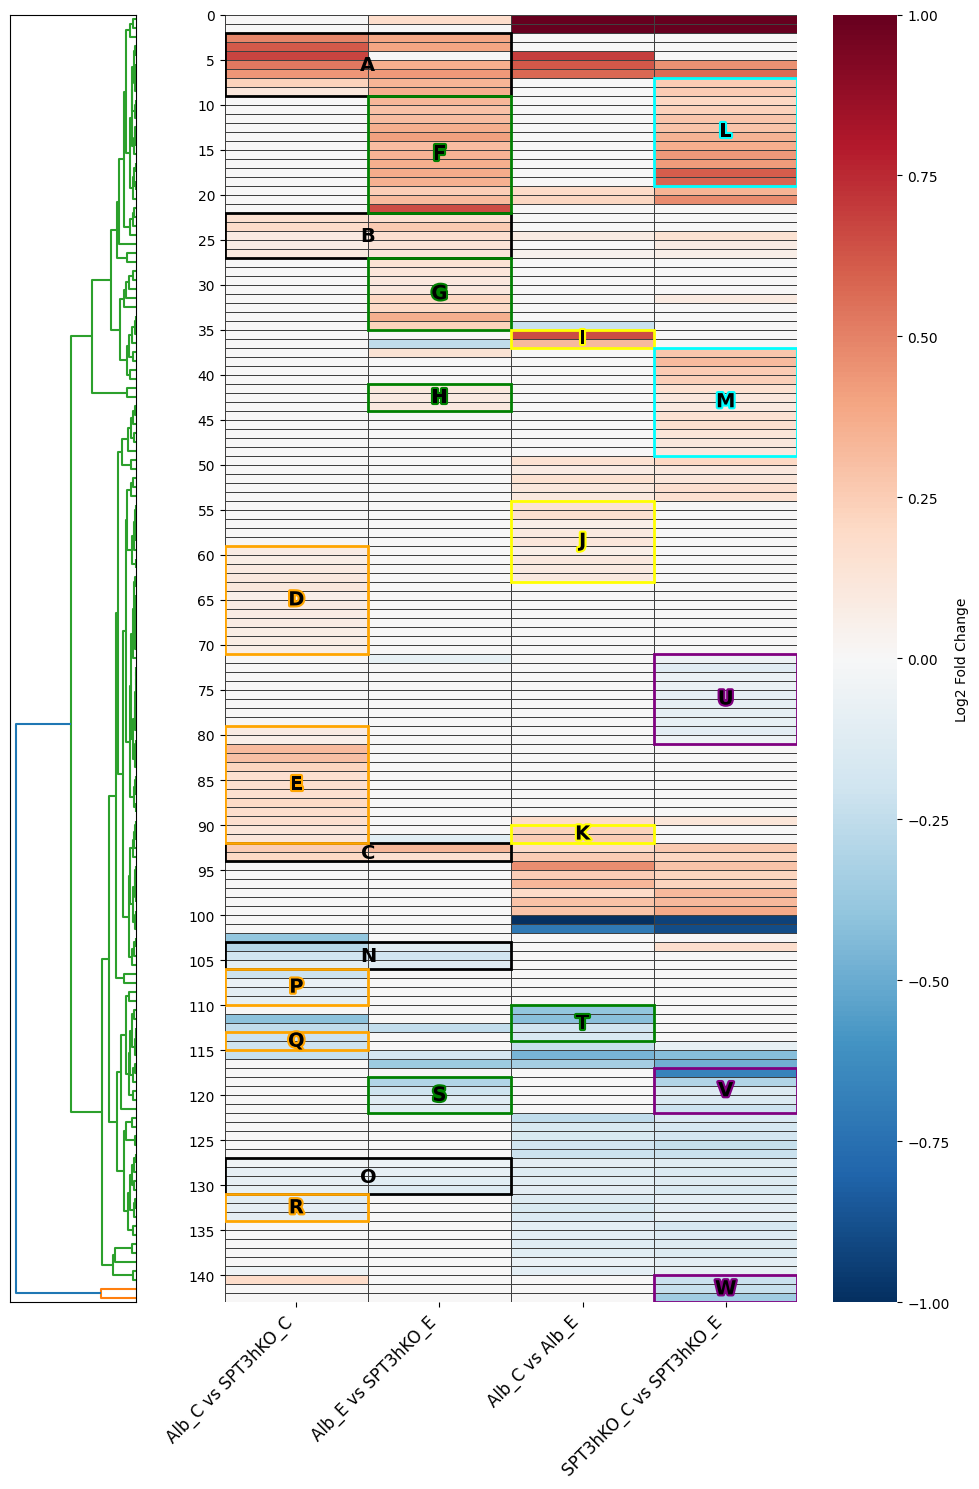

Saved group A data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_A.csv
Saved group B data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_B.csv
Saved group C data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_C.csv
Saved group D data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_D.csv
Saved group E data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_E.csv
Saved group F data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_F.csv
Saved group G data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_G.csv
Saved group H data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_H.csv
Saved group I data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_I.csv
Saved group J data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_J.csv
Saved group K data to /content/drive/MyDrive/Colab Notebooks/vcu/heatmap/group_K.csv
Saved group L data to /content/drive/MyDrive/Colab Notebooks/vcu/

In [ ]:
if __name__ == "__main__":
    input_csv = "statistic_analysis.csv"
    config_file = "config.json"

    heatmap_data = preprocess_data(input_csv, config_file)
    patterns = find_consecutive_patterns(
        "clustered_genes_log2fc_significance.csv",
        heatmap_data.columns
    )

    generate_heatmap(heatmap_data)

    # Save data for each group
    save_group_data("clustered_genes_log2fc_significance.csv", patterns, heatmap_data.columns)